<a href="https://colab.research.google.com/github/veereshthotigar/CSEE5590-490-AI-CyberSecurity-/blob/master/ICP6_add/Lecture_5_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install syft

In [0]:
# import packages
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms
import helper

In [3]:
import syft as sy
import torch as th


hook = sy.TorchHook(th)

W0716 00:05:44.253843 139673633998720 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0716 00:05:44.274894 139673633998720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [0]:
#create the workers
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
ted = sy.VirtualWorker(hook, id="ted")
carol = sy.VirtualWorker(hook, id="carol")
crypto_provider = sy.VirtualWorker(id="crypto_provider", hook=hook)



In [5]:
# Clear workers if previously holding any values
bob.clear_objects()
ted.clear_objects()
alice.clear_objects()
carol.clear_objects()
print(bob._objects)
print(alice._objects)
print(ted._objects)
print(carol._objects)

{}
{}
{}
{}


In [0]:
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 10
        self.save_model = False

args = Arguments()

use_cuda = not args.no_cuda and th.cuda.is_available()

th.manual_seed(args.seed)

device = th.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [7]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.FashionMNIST('../f_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=args.batch_size, shuffle=True, **kwargs)

# Download and load the test data
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../f_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

0it [00:00, ?it/s]

26427392it [00:02, 12913170.96it/s]                              


Extracting ../f_data/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 99487.18it/s]                            
0it [00:00, ?it/s]

Extracting ../f_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:01, 4085948.34it/s]                             
0it [00:00, ?it/s]

Extracting ../f_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 33544.47it/s]            


Extracting ../f_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
#Define your network architecture here
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

In [0]:
from torch import optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [10]:
#train the model
epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in federated_train_loader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        # TODO: Training pass
        model.send(images.location) 
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        model.get()
        
        
        running_loss += loss.get().item()
    else:
        print(f"Training loss: {running_loss/len(federated_train_loader)}")

Training loss: 1.3581454172444496
Training loss: 0.7138705290774546
Training loss: 0.5905360051436719
Training loss: 0.5341975124660077
Training loss: 0.5018990039348856


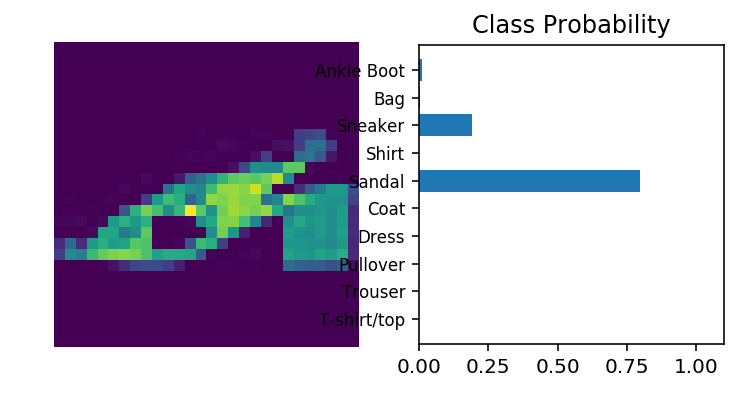

In [11]:
#validation with test data
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

# Test out your network!

dataiter = iter(test_loader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)

# Plot the image and probabilities
view_classify(img.resize_(1, 28, 28), ps, version='Fashion')
